# <font color='lightblue'>Answering Questions</font>

## <font color='lightblue'>1. Ask a question </font>

**Q1**: Layout your question of interest. Remember to state your question as clearly and simply as you can (Mark 1), and what your ideal outcome would be (Marks 1).

> How can we determine zoo animals taxon class based on their median life expectancy? The ideal outcome would be that my model is able to determine the taxon class and do it well.

**Q2**: Identify and describe what data sources you'll use (Marks 1). Make sure to talk about one of the following: data accuracy, reliability, validity, or sample selection. (Marks: 1)

> I will be using the dataset called "AZA_MLE_Jul2018" from data.world. The data also comes from the official Association of Zoo and Aquariums. The data is used in an article titled "Sex-specific median life expectancies from *ex situ* populations for 330 animal species". Some of the data may be unreliable since in the paper, they state "If the studbook dataset failed any of these tests, MLE cannot be reliably estimated and the estimate is marked as being “Data deficient". To make sure all my data is reliable, I decided to drop the rows where the columns "Data Deficient" have the word "yes" in it.

**Q3**: Layout what kind of ML problem you are facing and what kind of model you'll use to answer it (eg., is it unsupervised or supervised learning, and is it classification or regression). Make sure to say why. (Marks 1)

> I am using supervised learning and classification. I am using a model instead of clustering which makes my ML supervised. I am using `RandomForestClassifier` to predict the taxon class based on the median life expectancy and I'm not using any type of linear/logistic regression.

<br>

### **Setting up**

**Importing python libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib.axes import Axes
from sklearn import cluster
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

**Preparing the Theme of the Graphs**

In [2]:
dark = '#383838'
darker = '#1e1e1e'
light = '#ffffff'

def set_theme():
    plt.rcParams.update({
        'axes.edgecolor': light,
        'axes.facecolor': darker,
        'axes.labelcolor': light,
        'axes.labelpad': 20,
        'axes.labelsize': 14,
        'axes.labelweight': 500,
        'axes.titlepad': 20,
        'axes.titlesize': 16,
        'axes.titleweight': 600,
        'figure.facecolor': dark,
        'legend.fontsize': 12,
        'legend.title_fontsize': 14,
        'savefig.facecolor': dark,
        'text.color': light,
        'xtick.color': light,
        'xtick.labelsize': 14,
        'xtick.major.pad': 5.0,
        'ytick.color': light,
        'ytick.labelsize': 14,
        'ytick.major.pad': 5.0,
    })


def reset_theme():
    plt.rcParams.update(plt.rcParamsDefault)

def list_parameters():
    plt.rcParams.keys()

**Setting the Theme of the Graphs**

In [3]:
set_theme()

<br>

**Importing my data.**

In [4]:
usecols = [
  'Species Common Name',
  'Scientific Name',
  'TaxonClass',
  'Overall Sample Size',
  'Overall MLE',
  'Male Sample Size',
  'Male MLE',
  'Female Sample Size',
  'Female MLE',
  'Male Data Deficient',
  'Female Data Deficient',
]

zoo_animals = pd.read_csv('AZA_MLE_Jul2018.csv', usecols=usecols)

Here I make a list called `usecols` since some of my columns are just error-checking the dataset and have nothing to do with making predictions or analysis.

<br>

In [5]:
condition = (zoo_animals['Male Data Deficient'] == 'yes') | (zoo_animals['Female Data Deficient'] == 'yes')

zoo_animals = zoo_animals[~condition]

If the columns 'Male Data Deficient' or 'Female Data Deficient' have 'yes' in them, that means that the data might not be reliable. Here I am checking for that condition and removing the rows where it says 'yes' in the 'Male Data Deficient' and 'Female Data Deficient' columns

<br>

## <font color='lightblue'>2. Data understanding, exploration, and visualization </font>

**Action**: While above you gave an overview of the dataset(s) that will be used, here make sure that the reader understands the important details of the data. E.g., show a figure or descriptive statistic and explain why the reader should know about this, i.e., how will it help your reader understand your analysis? (Marks: 2)

### **Determining the types of data I am dealing with & handling missing data**

In [6]:
# Grabbing the data types of my dataset
zoo_animals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 247 entries, 0 to 329
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Species Common Name    247 non-null    object 
 1   Scientific Name        247 non-null    object 
 2   TaxonClass             247 non-null    object 
 3   Overall Sample Size    247 non-null    float64
 4   Overall MLE            247 non-null    float64
 5   Male Sample Size       247 non-null    float64
 6   Male MLE               247 non-null    float64
 7   Female Sample Size     247 non-null    float64
 8   Female MLE             247 non-null    float64
 9   Male Data Deficient    1 non-null      object 
 10  Female Data Deficient  0 non-null      object 
dtypes: float64(6), object(5)
memory usage: 23.2+ KB


Here we can see that I have 5 columns that consist of `strings` and 6 columns that consist of `integers`.

In [7]:
# Seeing if there's any missing data
zoo_animals.isna().sum()

Species Common Name        0
Scientific Name            0
TaxonClass                 0
Overall Sample Size        0
Overall MLE                0
Male Sample Size           0
Male MLE                   0
Female Sample Size         0
Female MLE                 0
Male Data Deficient      246
Female Data Deficient    247
dtype: int64

The "Male Data Deficient" and "Female Data Deficient" columns cannot be dropped, even though it says they have missing data. Earlier, I dropped all the data deficient rows (the unreliable data) so them having missing data means that I'm using the reliable data.

In [8]:
# Taking a look at dataset
zoo_animals.head(5)

,Species Common Name,Scientific Name,TaxonClass,Overall Sample Size,Overall MLE,Male Sample Size,Male MLE,Female Sample Size,Female MLE,Male Data Deficient,Female Data Deficient
0,Addax,Addax nasomaculatus,Mammalia,1215.0,13.4,558.0,12.3,656.0,14.4,NaN,NaN
1,"Agouti, Brazilian",Dasyprocta leporina,Mammalia,456.0,8.1,216.0,8.8,220.0,7.8,NaN,NaN
6,"Antelope, Sable",Hippotragus niger,Mammalia,1398.0,11.3,602.0,10.6,795.0,11.6,NaN,NaN
7,"Aracari, Green",Pteroglossus viridis,Aves,358.0,7.9,174.0,8.5,175.0,7.6,NaN,NaN
8,"Argus, Great",Argusianus argusÊ,Aves,310.0,10.8,138.0,10.6,160.0,11.1,NaN,NaN


<br>

### **Estimating the summary statistics of some of the key variables**.

Since I am only using median life expectancy (MLE) for my model and analysis, I will make them my key variables.

In [9]:
zoo_animals['Overall MLE'].describe()

count    247.000000
mean      12.087449
std        6.721459
min        2.400000
25%        7.300000
50%       10.800000
75%       15.150000
max       42.000000
Name: Overall MLE, dtype: float64

In [10]:
zoo_animals['Male MLE'].describe()

count    247.000000
mean      12.071255
std        6.485784
min        2.600000
25%        7.400000
50%       10.700000
75%       15.750000
max       35.700000
Name: Male MLE, dtype: float64

In [11]:
zoo_animals['Female MLE'].describe()

count    247.000000
mean      12.044534
std        6.982426
min        2.400000
25%        7.100000
50%       10.700000
75%       14.950000
max       43.300000
Name: Female MLE, dtype: float64

I found that males zoo animals have a slightly higher mean of median life expectancy than femals. However, females have a higher maximum median life expectancy than males.

<br>

### **Visualizing the distribution of values for some key variables, and the relationships between key variables.**

(0.0, 80.0)

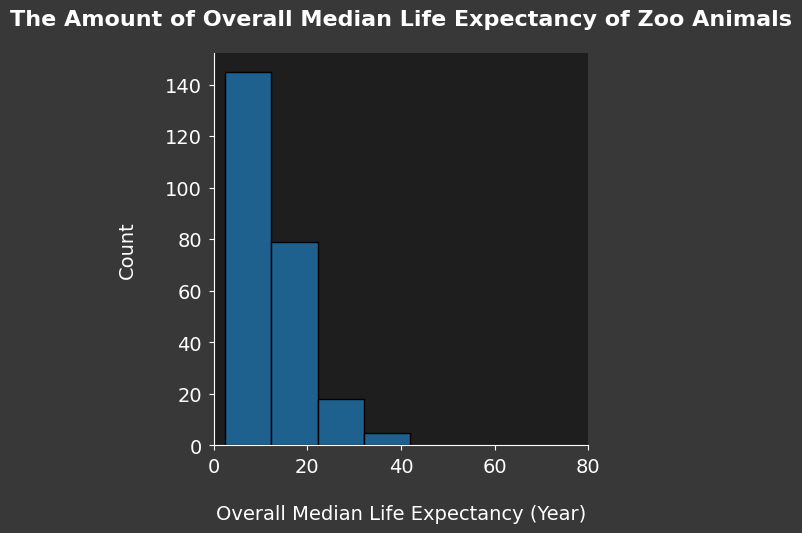

In [12]:
sns.displot(zoo_animals, x = 'Overall MLE', binwidth = 10).set(xlabel='Overall Median Life Expectancy (Year)', title='The Amount of Overall Median Life Expectancy of Zoo Animals')
plt.xlim(0,80)

In the plot above, it shows that the majority overall median life expectancy in the dataset ranges from around 2 to 13. That means that overall, zoo animals usually live to the 2-13 year range.
<br>
The least overall median life expectancy in the dataset ranges from 33 to 43 That means that zoo animals rarely live to the 33-43 year range.

(0.0, 55.0)

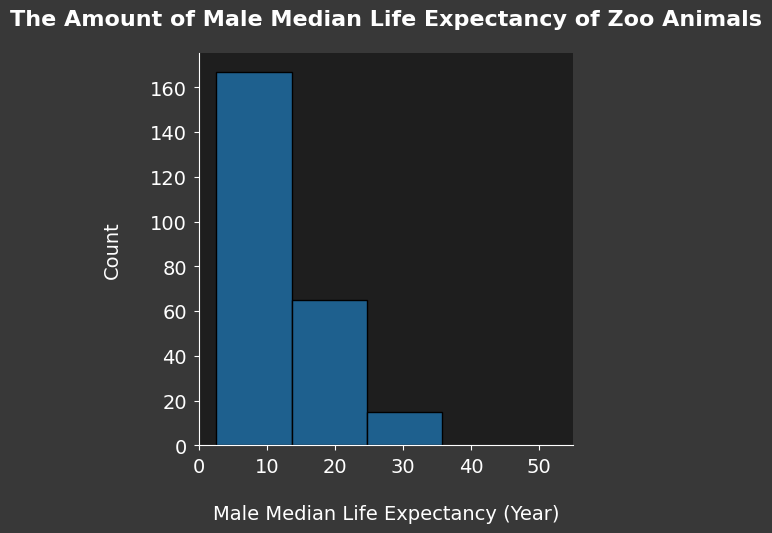

In [13]:
sns.displot(zoo_animals, x='Male MLE', binwidth=10).set(xlabel='Male Median Life Expectancy (Year)', title='The Amount of Male Median Life Expectancy of Zoo Animals')
plt.xlim(0,55)

In the plot above, it shows that the majority male median life expectancy in the dataset ranges from around 2 to 12. That means that male zoo animals usually live to the 2-12 year range.
<br>
The least male median life expectancy in the dataset ranges from 22 to 32 That means that male zoo animals rarely live to the 22-32 year range.

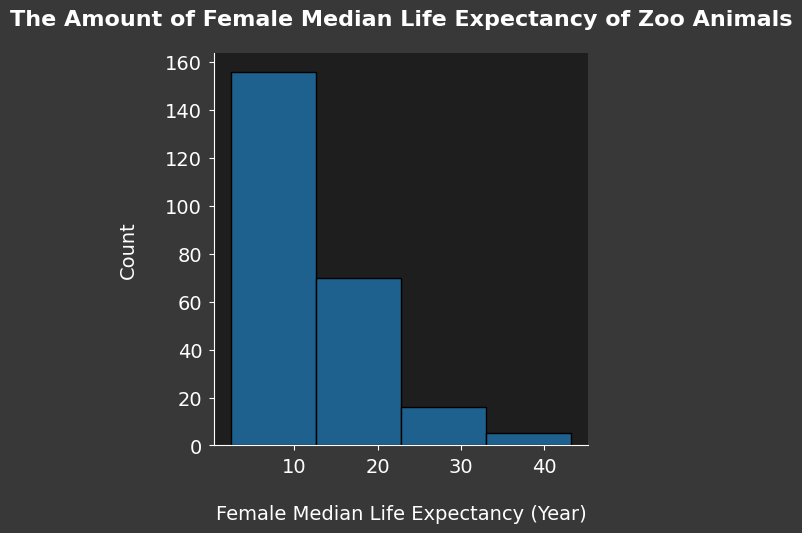

In [14]:
sns.displot(zoo_animals, x='Female MLE', binwidth=10).set(xlabel='Female Median Life Expectancy (Year)', title='The Amount of Female Median Life Expectancy of Zoo Animals')

In the plot above, it shows that the majority female median life expectancy in the dataset ranges from around 2 to 12. That means that female zoo animals usually live to the 2-12 year range.
<br>
The least female median life expectancy in the dataset ranges from 33 to 42. That means that female zoo animals rarely live to the 33-42 year range.

We can see that in the "Female Median Life Expectancy" graph, females have a range of around 33 to 42 while the "Male Median Life Expectancy" graph does not.

[Text(0.5, 0, 'Overall Median Life Expectancy (Year)'),
 Text(0, 0.5, 'Different Taxon Classes'),
 Text(0.5, 1.0, 'Overall Median Life Expectancy of Taxon Class')]

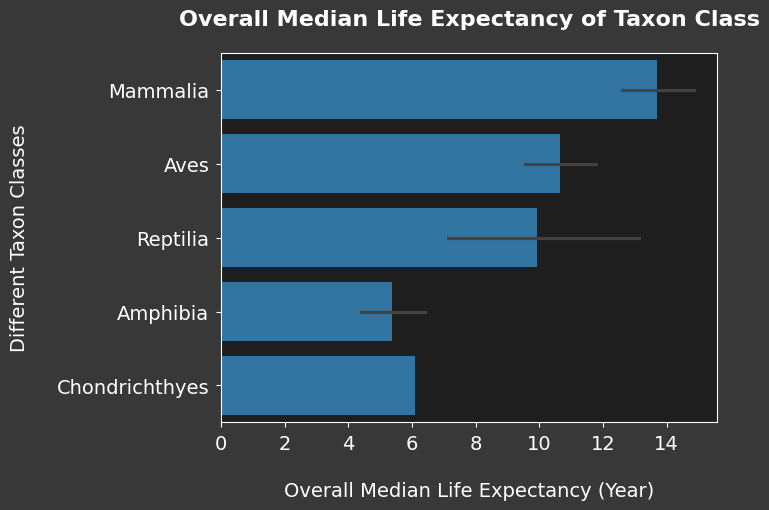

In [15]:
sns.barplot(data=zoo_animals, x='Overall MLE', y='TaxonClass').set(xlabel='Overall Median Life Expectancy (Year)', ylabel='Different Taxon Classes', title='Overall Median Life Expectancy of Taxon Class')

In the plot above, it shows that the taxon class, Mammalia, has the highest overall median life expectancy of zoo animals.
<br>
Amphibia has the lowest overall median life expectancy.

[Text(0.5, 0, 'Male Median Life Expectancy (Year)'),
 Text(0, 0.5, 'Different Taxon Classes'),
 Text(0.5, 1.0, 'Male Median Life Expectancy of Taxon Class')]

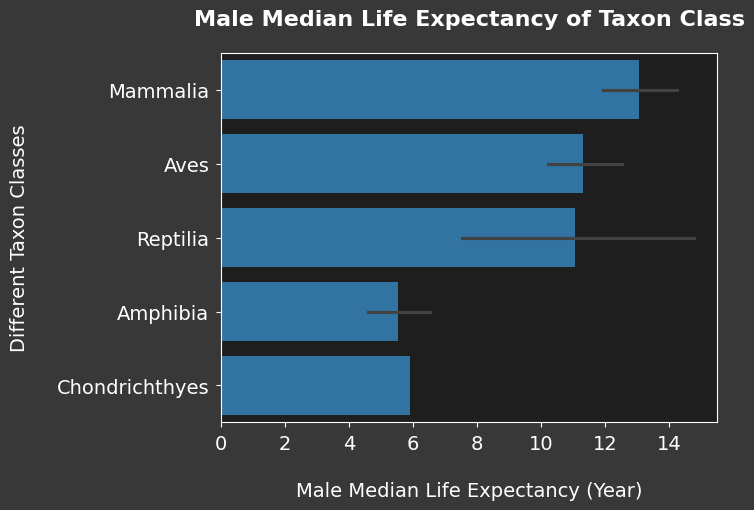

In [16]:
sns.barplot(data=zoo_animals, x='Male MLE', y='TaxonClass').set(xlabel='Male Median Life Expectancy (Year)', ylabel='Different Taxon Classes', title='Male Median Life Expectancy of Taxon Class')

In the plot above, it shows that the taxon class, Mammalia, has the highest male median life expectancy of zoo animals.
<br>
Amphibia has the lowest male median life expectancy.

[Text(0.5, 0, 'Female Median Life Expectancy (Year)'),
 Text(0, 0.5, 'Different Taxon Classes'),
 Text(0.5, 1.0, 'Female Median Life Expectancy of Taxon Class')]

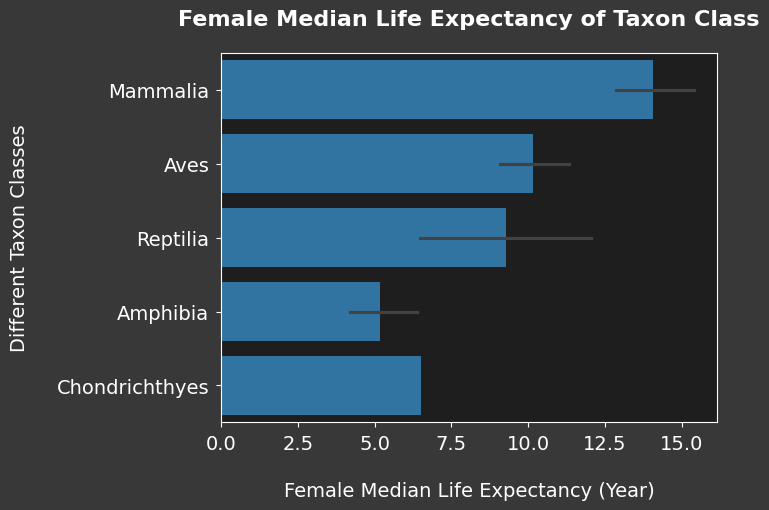

In [17]:
sns.barplot(data=zoo_animals, x='Female MLE', y='TaxonClass').set(xlabel='Female Median Life Expectancy (Year)', ylabel='Different Taxon Classes', title='Female Median Life Expectancy of Taxon Class')

In the plot above, it shows that the taxon class, Mammalia, has the highest female median life expectancy of zoo animals.
<br>
Amphibia has the lowest female median life expectancy.

Therefore, we can assume that Mammalia has the highest median life expectancy of zoo animals and that Amphibia has the lowest median life expectancy.

<br>

### **Using correlations to estimate the relationship between some of the key variables.**

<Axes: >

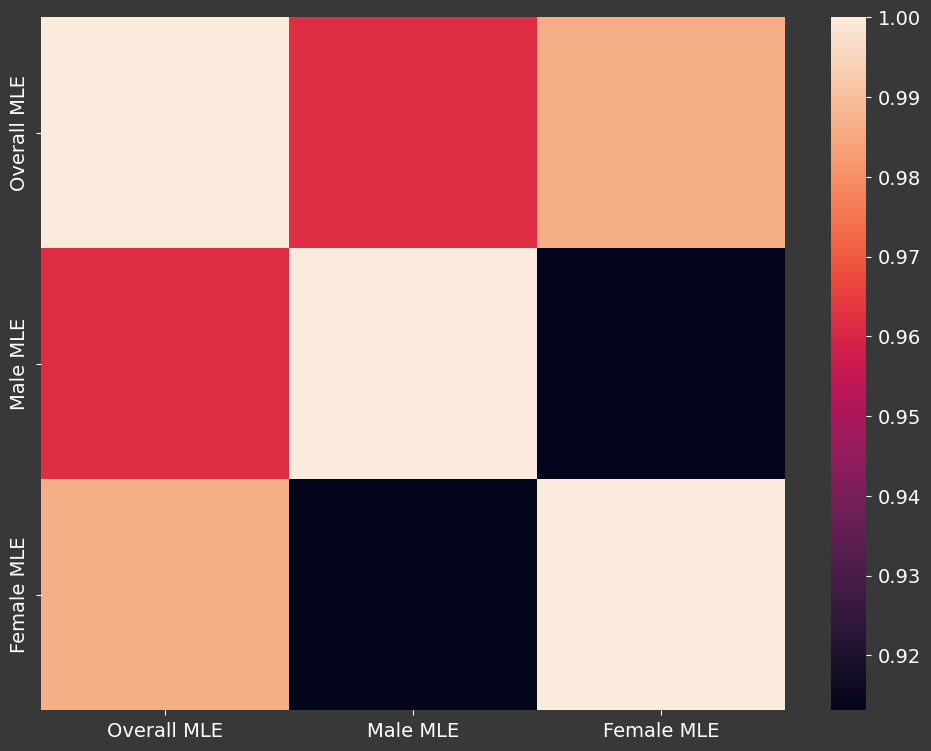

In [18]:
zoo_animal_heatmap = zoo_animals[
  [
    'Overall MLE',
    'Male MLE',
    'Female MLE'
  ]
]

zoo_corrmat = zoo_animal_heatmap.corr()
plt.subplots(figsize = (12,9))
sns.heatmap(zoo_corrmat, square=False)

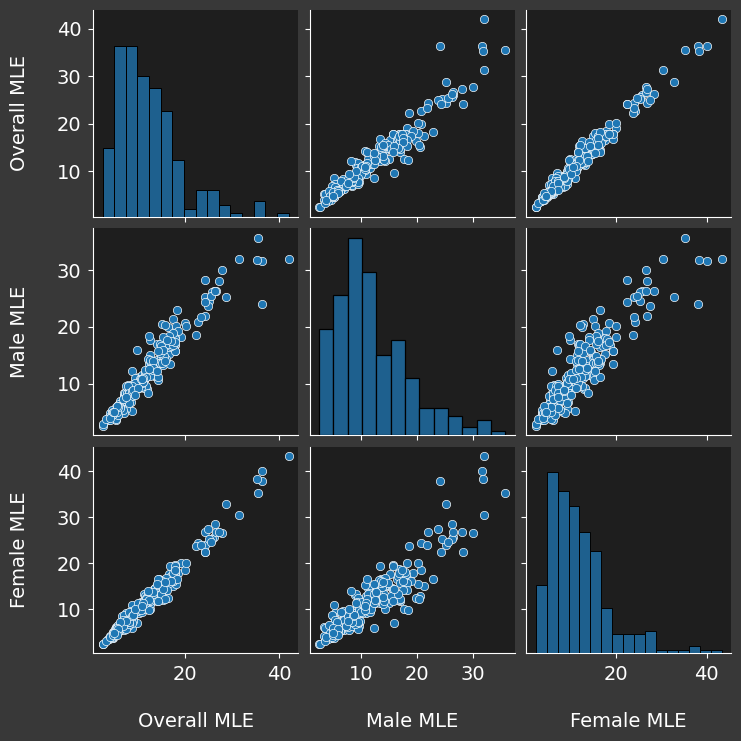

In [19]:
zoo_animal_corr = zoo_animals[
  [
    'Overall MLE',
    'Male MLE',
    'Female MLE'
  ]
]

sns.pairplot(zoo_animal_corr)

In [20]:
zoo_animals['Female MLE'].corr(zoo_animals['Male MLE'])

0.9131291026648214

In [21]:
zoo_animals['Female MLE'].corr(zoo_animals['Overall MLE'])

0.986367968298365

Here it shows that while "Female MLE" and "Male MLE" are correlated, they aren't as correlated as "Female MLE" and "Overall MLE".

In the correlation graph, we can see that the correlations between "Male MLE" and "Female MLE" is more spread out and has a magnitude of 0.91. Therefore, we can say that the correlation between "Male MLE" and "Female MLE" is a highly positive correlation, and same goes for the correlation between "Female MLE" and "Overall MLE".

The graph and heatmap also show that all of my variables are positively correlated with one another.

<br>

## <font color='lightblue'>3. Data wrangling and preprocessing </font>

**Action**: Layout all your data wrangling and preprocessing steps so that a reader will understand why you took each step, and would be able to reproduce your steps. (Marks: 3)

**Preprocessing categorical target variable**

In [22]:
# Categorical variable
target_names = ['TaxonClass']

# Creating the Ordinal Encoder object
ordinal_encoder = OrdinalEncoder()

# Using this object to fit (i.e., to calculate the mean and sd of each variable in the training data) and then to transform the training data
zoo_animals[target_names] = ordinal_encoder.fit_transform(zoo_animals[target_names])

# Taking a look
zoo_animals

,Species Common Name,Scientific Name,TaxonClass,Overall Sample Size,Overall MLE,Male Sample Size,Male MLE,Female Sample Size,Female MLE,Male Data Deficient,Female Data Deficient
0,Addax,Addax nasomaculatus,3.0,1215.0,13.4,558.0,12.3,656.0,14.4,NaN,NaN
1,"Agouti, Brazilian",Dasyprocta leporina,3.0,456.0,8.1,216.0,8.8,220.0,7.8,NaN,NaN
6,"Antelope, Sable",Hippotragus niger,3.0,1398.0,11.3,602.0,10.6,795.0,11.6,NaN,NaN
7,"Aracari, Green",Pteroglossus viridis,1.0,358.0,7.9,174.0,8.5,175.0,7.6,NaN,NaN
8,"Argus, Great",Argusianus argusÊ,1.0,310.0,10.8,138.0,10.6,160.0,11.1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
325,"Woodhoopoe, Green",Phoeniculus purpureus,1.0,284.0,5.4,136.0,6.0,130.0,4.3,NaN,NaN
326,"Wood-partridge, Crested",Rollulus rouloul,1.0,1319.0,4.8,645.0,5.0,633.0,4.7,NaN,NaN
327,"Zebra, Grevy's",Equus grevyi,3.0,797.0,14.1,341.0,11.2,455.0,16.5,NaN,NaN
328,"Zebra, Hartmann's Mountain",Equus zebra hartmannae,3.0,585.0,13.9,283.0,12.3,301.0,15.4,NaN,NaN


<br>

**Splitting data**

In [23]:
# Spliting data into predictors (X) and target (y)
x = zoo_animals[['Overall MLE', 'Male MLE', 'Female MLE']]
y = zoo_animals['TaxonClass']

# Spliting these data into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

<br>

**Taking a look at the splitted data**

In [24]:
# Taking a look at x training dataset
x_train.shape

(197, 3)

In [25]:
# Taking a look at y training dataset
y_train.shape

(197,)

In [26]:
# Taking a look at x testing dataset
x_test.shape

(50, 3)

In [27]:
# Taking a look at y testing dataset
y_test.shape

(50,)

<br>

**Scaling numeric variables**

In [28]:
# Scaling any numeric variables

# Numeric variables
num_names = zoo_animals[['Overall MLE', 'Male MLE', 'Female MLE']].select_dtypes(include='number').columns.tolist()

# Creating the standard scaler object
sc = StandardScaler()

# Using this object to fit (i.e., to calculate the mean and sd of each variable in the training data) and then to transform the training data
x_train[num_names] = sc.fit_transform(x_train[num_names])

# Using the fit from the training data to transform the test data
x_test[num_names] = sc.transform(x_test[num_names])

# Taking a look
x_train

,Overall MLE,Male MLE,Female MLE
204,2.434541,1.955593,2.932349
184,-0.408848,-0.181100,-0.430834
170,0.445642,0.390691,0.448986
248,-0.173127,-0.286430,-0.076068
21,-0.585639,-0.587373,-0.586931
...,...,...,...
56,0.062595,0.059654,0.108411
179,1.786307,1.955593,1.669382
14,1.005480,0.902293,1.115946
264,-0.114196,-0.045676,-0.288927


## <font color='lightblue'>4. Build and test a model</font>



**Action:** Use your training dataset to build a model with the goal addressing your question of interest. (Marks: 2)

**Figuring Out the Best Parameters for the RandomForestClassifier**

In [29]:
# Define what parameters and what values to vary
parameters = {'max_features': [0.5,0.7,0.9,1.0],
              'n_estimators':list(range(50,200,50)),
              'max_samples':[0.5,0.7,0.9,0.99],
              'max_depth': [3, 4, 5] }

# Building the grid search algorithm
grid_search = GridSearchCV(RandomForestClassifier(), parameters, cv=5, scoring='accuracy') #strattified cross validation when traget is binary or multiclass

# Using training data to perform the nfold cross validation
grid_search.fit(x_train, y_train)

# Finding the best hyperparameters
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

D:\Code\University\zoo\venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'max_depth': 3, 'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 100}
0.6243589743589744
RandomForestClassifier(max_depth=3, max_features=0.7, max_samples=0.7)


<br>

**Building the Optimized Random Forest Algorithm**

In [30]:
# Building an optimized model
forest_classifier_opt = grid_search.best_estimator_

# Fitting the model to the data
forest_classifier_opt.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, max_features=0.7, max_samples=0.7)

<br>

**Q4**: Measure the performance of your model, and describe how well your model generalizes to new data (Marks: 2)

**Estimating performance and prediction of training data**

In [31]:
# Making predictions for training
y_forest_pred_opt_train = forest_classifier_opt.predict(x_train)

Text(21.416666666666664, 0.5, 'True label')

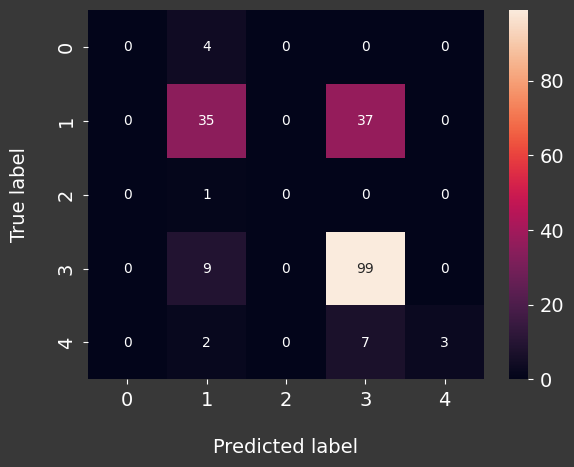

In [32]:
# Calculating the confusion matrix
cm_forest_opt = confusion_matrix(y_train, y_forest_pred_opt_train)

# Plotting the confusion matrix
sns.heatmap(cm_forest_opt, annot=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')

In [33]:
# Measuring accuracy for training

accuracy_score = sk.metrics.accuracy_score(y_train, y_forest_pred_opt_train)
precision_score = sk.metrics.precision_score(y_train, y_forest_pred_opt_train, average='micro')
recall_score = sk.metrics.recall_score(y_train, y_forest_pred_opt_train, average='micro')

print(f"Accuracy: {accuracy_score:.2f}")
print(f"Precision: {precision_score:.2f}")
print(f"Recall: {recall_score:.2f}")

Accuracy: 0.70
Precision: 0.70
Recall: 0.70


<br>

**Estimating performance and prediction of testing data**

In [34]:
# Making predictions for test
y_forest_pred_opt = forest_classifier_opt.predict(x_test)

Text(21.416666666666664, 0.5, 'True label')

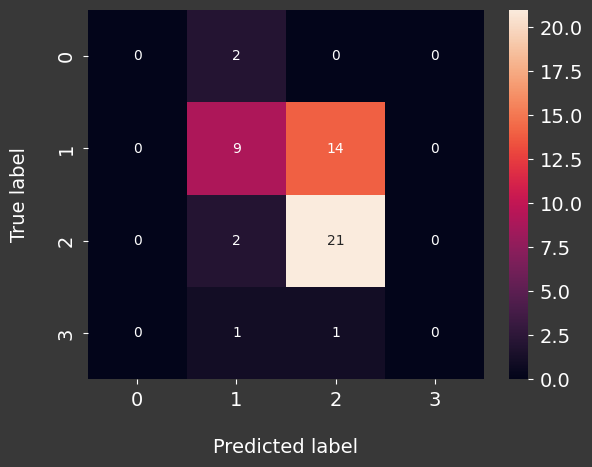

In [35]:
# Calculating the confusion matrix
cm_forest_opt = confusion_matrix(y_test, y_forest_pred_opt)

# Plotting the confusion matrix
sns.heatmap(cm_forest_opt, annot=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')

In [36]:
# Measuring accuracy for test

accuracy_score = sk.metrics.accuracy_score(y_test, y_forest_pred_opt)
precision_score = sk.metrics.precision_score(y_test, y_forest_pred_opt, average='micro')
recall_score = sk.metrics.recall_score(y_test, y_forest_pred_opt, average='micro')

print(f"Accuracy: {accuracy_score:.2f}")
print(f"Precision: {precision_score:.2f}")
print(f"Recall: {recall_score:.2f}")

Accuracy: 0.60
Precision: 0.60
Recall: 0.60


My model generalizes decently to new data. It's picking up on learning new data opposed to memorizing, which is reflected in the difference between the accuracy scores. Therefore, the relationships learnt in my training dataset, were also found in my testing data.

<br>

## <font color='lightblue'>5. Interpret your model</font>

**Q5**: Interpret your model results. E.g., what features contributed to your predictions, if possible, can you determine the sign and magnitude of the effect (Marks: 2).

**Evaluating What is Being Used by the Model to Make Predictions for Training Data**

In [37]:
# Using permutation importance for training
perm_result_train = permutation_importance(forest_classifier_opt, X=x_train, y=y_train, scoring='accuracy', n_repeats=30)

# Placing values into a dataframe
forest_importances_train = pd.DataFrame({'Variable':x_train.columns,'Importance':perm_result_train.importances_mean.round(4), "sd":perm_result_train.importances_std.round(4)})

# Sorting the dataframe
forest_importances_train.sort_values(by='Importance', ascending=False)

,Variable,Importance,sd
2,Female MLE,0.1946,0.0279
1,Male MLE,0.0760,0.0171
0,Overall MLE,0.0061,0.0080


<Axes: xlabel='Variable', ylabel='Importance'>

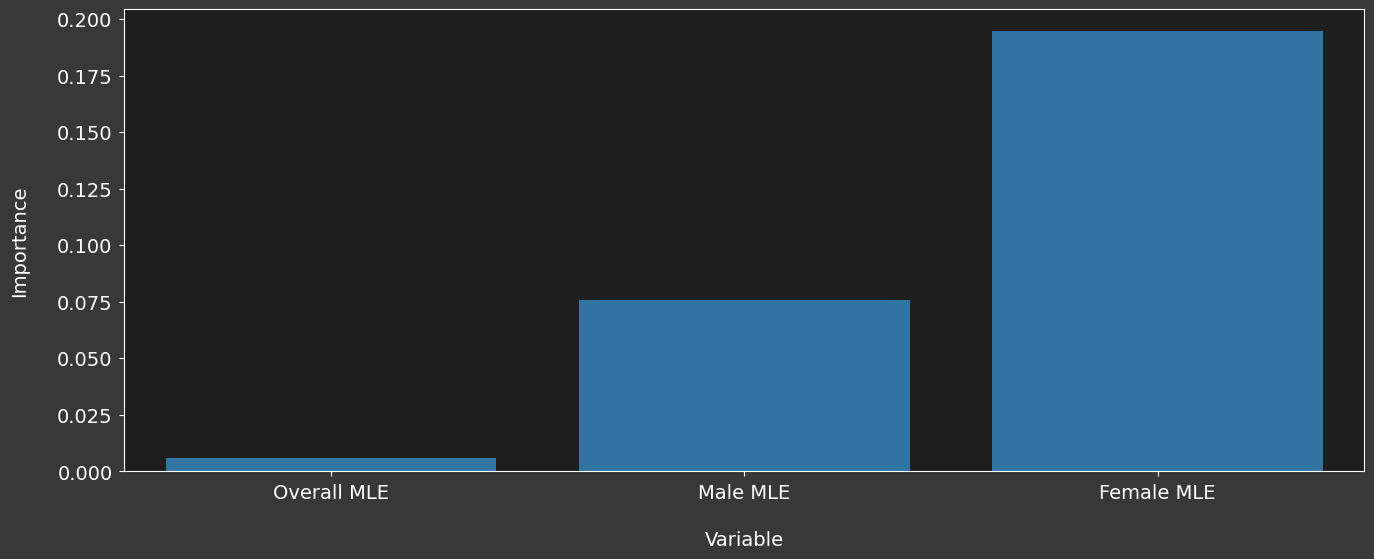

In [38]:
# Plotting the importance
fig, ax = plt.subplots(
    figsize=(16, 6)
)

sns.barplot(data=forest_importances_train, x='Variable', y='Importance')

**Evaluating What is Being Used by the Model to Make Predictions for Testing Data**

In [39]:
from sklearn.inspection import permutation_importance

# Using permutation importance for testing
perm_result = permutation_importance(forest_classifier_opt, X=x_test, y=y_test, scoring='accuracy', n_repeats=30)

# Placing values into a dataframe
forest_importances = pd.DataFrame({'Variable':x_test.columns,'Importance':perm_result.importances_mean.round(4), "sd":perm_result.importances_std.round(4)})

# Sorting the dataframe
forest_importances.sort_values(by='Importance', ascending=False)

,Variable,Importance,sd
2,Female MLE,0.1160,0.0623
1,Male MLE,0.0680,0.0415
0,Overall MLE,-0.0093,0.0277


<Axes: xlabel='Variable', ylabel='Importance'>

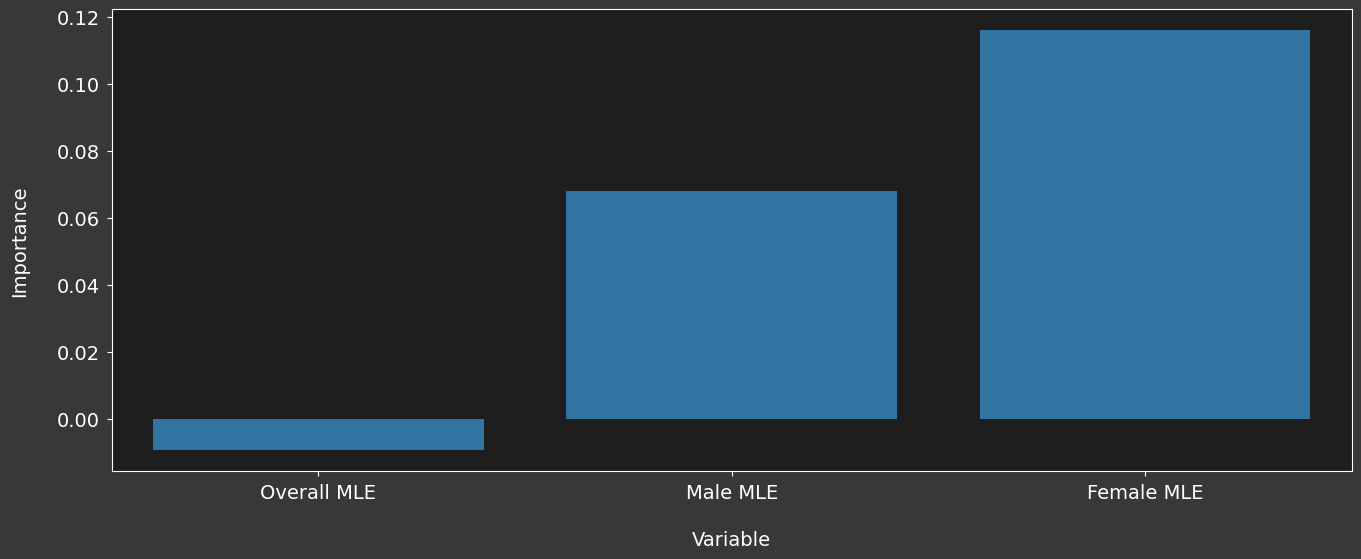

In [40]:
# Plotting the importance
fig, ax = plt.subplots(
    figsize=(16, 6)
)

sns.barplot(data=forest_importances, x='Variable', y='Importance')

The features that contributed to my predictions were "Female MLE", "Male MLE", and "Overall MLE". It seems that a majority of the time, "Female MLE" has a greater importances and impact on my model's prediction than "Male MLE" and "Overall MLE". Since all of the variables I use are above 0, that means that the effect is positive.



<br>

## <font color='lightblue'>6. Answer your question</font>

**Q6:** Use your analysis above to answer your question of interest. Did you achieve your desired outcome, and what might the next steps be? Remember to write as though you are writing to team mates working on the same/similar problem. (Marks: 3)


Note: It is ok if your analysis doesn't provide a strong answer, you can point out where it failed. If anything you can cross the approach you took off the list of possible ways to tackle your question. I.e., you still made progress!

> While I did achieve my desired outcome and it was able to predict the taxon class based on the median life expectancy, it didn't do it very well. I would've liked my accuracy to be somewhere in the 80-90 range instead of the 50-60 range. I think the next steps would be to see if there's other median life expectancy of zoo animals data that I can combine with this dataset to see if it could help my model have a higher accuracy. Another step could be to use another model such as multiclass classification logistic regression or XGBoost classifier to see if they improve my predictions. I also think it would be very cool to actually go to a zoo and gather data on animals life expectancy.